In [ ]:
import os
import sys
import shutil
from pathlib import Path

TEMP_BASE = "/tempory/cg/deepl/dclip"
os.environ["HF_HOME"] = TEMP_BASE
os.environ["TORCH_HOME"] = os.path.join(TEMP_BASE, "torch")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(TEMP_BASE, "transformers")
os.environ["HF_DATASETS_CACHE"] = os.path.join(TEMP_BASE, "datasets")

clip_cache_dir = os.path.join(TEMP_BASE, "clip")
os.makedirs(clip_cache_dir, exist_ok=True)

home_cache_dir = Path.home() / ".cache"
home_clip_link = home_cache_dir / "clip"
home_cache_dir.mkdir(parents=True, exist_ok=True)

if not home_clip_link.is_symlink():
    if home_clip_link.exists():
        print(f"Nettoyage de l'ancien cache : {home_clip_link}")
        shutil.rmtree(home_clip_link)
    os.symlink(clip_cache_dir, home_clip_link)

os.environ["HF_DATASETS_OFFLINE"] = "0"
os.environ["HF_HUB_OFFLINE"] = "0"

custom_package_path = "/tempory/cg/deepl/dclip/package"
if custom_package_path not in sys.path:
    sys.path.append(custom_package_path)

path_to_dclip = os.path.join(os.path.expanduser("~"), "M2/DEEPL/Projet/v2")

if path_to_dclip not in sys.path:
    sys.path.append(path_to_dclip)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import concatenate_datasets
from torch.utils.data import DataLoader


try:
    import clip
    print(f"CLIP chargé depuis : {clip.__file__}")
except ImportError:
    print("CLIP officiel introuvable. Installation en cours dans /tempory...")
    !pip install --target={custom_package_path} git+https://github.com/openai/CLIP.git
    
    import importlib
    importlib.invalidate_caches()
    import clip
    print(f"CLIP installé et chargé depuis : {clip.__file__}")

import clip.model as clip_model
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

CLIP = clip_model.CLIP
_tokenizer = _Tokenizer()

print("Environnement prêt (Version Officielle)")

/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.11/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


CLIP chargé depuis : /tempory/cg/deepl/dclip/package/clip/__init__.py
Environnement prêt (Version Officielle)


In [2]:
def get_best_device():
    """Returns the best device on this computer"""

    if torch.cuda.is_available():
        device = torch.device("cuda")
        total_memory = torch.cuda.get_device_properties(device).total_memory
        print(f"GPU Memory: {total_memory / 1e9:.1f} GB")
        print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Found device: {device}")
    return device


device = get_best_device()

GPU Memory: 21.0 GB
GPU Name: NVIDIA RTX A4500
Found device: cuda


In [34]:
%load_ext autoreload
%autoreload 2
    
from dclip import *
from eval import *
from utils import *
from train import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def count_parameters(model):
    # Paramètres qui seront mis à jour par l'optimiseur
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Tous les paramètres (y compris le ViT gelé)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Percentage Trainable: {100 * trainable_params / total_params:.2f}%")

In [5]:
from datasets import load_dataset

dataset = load_dataset(
    "mteb/VOC2007",
    cache_dir="/tempory/cg/deepl/dclip/hf_datasets"
)

train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

print(train_ds)
print(test_ds)


Dataset({
    features: ['image', 'classes'],
    num_rows: 2501
})
Dataset({
    features: ['image', 'classes'],
    num_rows: 4952
})


In [6]:
VOC2007_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
VOC2007_CLASSES = np.array(VOC2007_CLASSES)

In [ ]:
class VOCHFDataset(Dataset):
    def __init__(self, hf_ds, class_names, transform=None):
        self.ds, self.class_names, self.transform = hf_ds, class_names, transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        
        img = item["image"].convert("RGB")
        if self.transform: 
            img = self.transform(img)

        vec = torch.zeros(len(self.class_names))
        
        label_list = item.get("classes", [])
        
        for i in label_list:
            if i < len(self.class_names):
                vec[i] = 1.0
                
        return img, vec

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(448, scale=(0.7, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

test_transform = transforms.Compose([
    transforms.Resize((448, 448), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [ ]:
trainval_ds = concatenate_datasets([train_ds, val_ds])

train_dataset = VOCHFDataset(
    trainval_ds, 
    VOC2007_CLASSES, 
    transform=train_transform
)

test_dataset = VOCHFDataset(
    test_ds,
    VOC2007_CLASSES,
    transform=test_transform
)

print(len(train_dataset))

5011


In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

print(f"Test batches: {len(test_loader)}")
print(f"Train batches: {len(train_loader)}")

Test batches: 155
Train batches: 157


In [11]:
CHECKPOINT_PATH = "/tempory/cg/deepl/dclip/saves/best_dclip_model.pth"

In [32]:
model = dclip(VOC2007_CLASSES, clip_type="ViT-B/16")
model = model.to(device)


--- [INIT DCLIP] ---
Logit Scale: 7
Fixed Text Features shape: torch.Size([40, 512]) (Attendu: [2*N, 512])
Detected ViT Output Dim: 512
Trainable parameters: 427,648


In [ ]:
asl_criterion = AsymmetricLossOptimized(gamma_neg=2, gamma_pos=1, clip=0.05).to(device)
mfi_criterion = MFILossOpti(lambda_coeff=0.2).to(device)

optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.002,
    momentum=0.9,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

num_epochs = 30
best_map = 0.0
alpha = 7e-5

print(f"Starting Training on {device}...")

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        logits, class_text_features = model(images)
        
        loss_asl = asl_criterion(logits, labels)
            
        loss_mfi = mfi_criterion(class_text_features)

        loss = loss_asl + alpha * loss_mfi
    
        loss.backward()

        optimizer.step()


        epoch_loss += loss.item()
        pbar.set_postfix({"ASL": f"{loss_asl.item():.4f}", "MFI": f"{alpha*loss_mfi.item():.4f}"})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch} Average Loss: {avg_epoch_loss:.4f}")
    
    # Step scheduler every epoch
    scheduler.step()
    
    # 5. Periodic Evaluation
    if epoch % 5 == 0 or epoch == 1:
        print(f"\n--- Periodic Evaluation (Epoch {epoch}) ---")
        current_map, cp = evaluate_dclip_model(model, test_loader, VOC2007_CLASSES, device=device)
        print(f"Test mAP: {current_map:.4f}  |  CP: {cp:.4f}")

        
        if current_map > best_map and False:
            best_map = current_map
            save_checkpoint(model, optimizer, epoch, best_map, CHECKPOINT_PATH)
            print("⭐ New Best Model Saved!")

print(f"\nTraining Finished! Best mAP attained: {best_map:.4f}") #MAP : 0.1780

Starting Training on cuda...


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:31<00:00,  1.71it/s, ASL=31.2125, MFI=0.0213]


Epoch 1 Average Loss: 55.9627

--- Periodic Evaluation (Epoch 1) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [01:32<00:00,  1.68it/s]


  mAP    : 0.1240
  CP     : 0.4053
Test mAP: 0.1240  |  CP: 0.4053


Epoch 2/30:  21%|███████████████████████████▉                                                                                                         | 33/157 [00:20<01:17,  1.60it/s, ASL=54.7847, MFI=0.0213]


KeyboardInterrupt: 

Visualisation de l'image n°1822 | Classe ciblée : '['person' 'horse']'


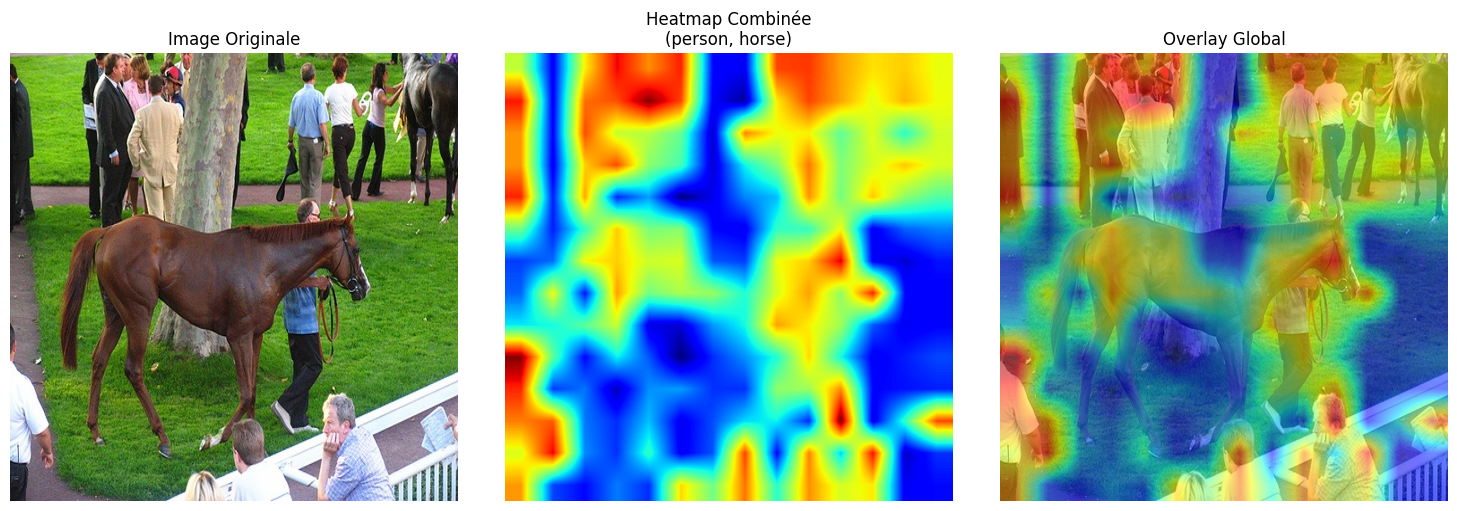

In [ ]:
model.eval()

# Tirer une image au hasard dans le dataset de test
# index = np.random.randint(0, len(dataset["test"]))
# sample = dataset["test"][index]

while True:
    index = np.random.randint(0, len(dataset["test"]))
    sample = dataset["test"][index]
    
    # Si la liste contient plus d'1 élément, on garde l'image
    if len(sample["classes"]) > 1:
        break



image_pil = sample["image"]

# Récupérer le nom de la première classe présente dans l'image
class_index = sample["classes"]
class_name = VOC2007_CLASSES[class_index]

print(f"Visualisation de l'image n°{index} | Classe ciblée : '{class_name}'")

# Lancer la fonction de visualisation
visualize_segmentation_dclip(model, image_pil, class_name, device=device)

Visualisation de l'image n°623 | Classe ciblée : '['chair' 'person' 'sofa']'


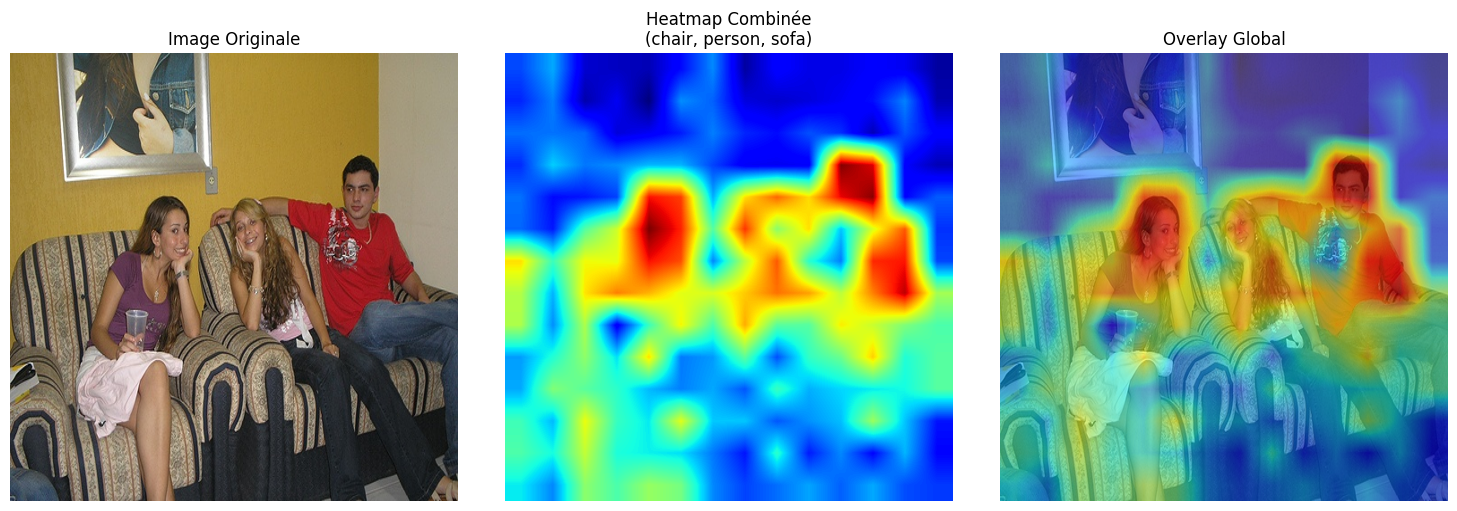

In [204]:
model.eval()
while True:
    index = np.random.randint(0, len(dataset["train"]))
    sample = dataset["train"][index]
    
    if len(sample["classes"]) > 1:
        break



image_pil = sample["image"]

class_index = sample["classes"]
class_name = VOC2007_CLASSES[class_index]

print(f"Visualisation de l'image n°{index} | Classe ciblée : '{class_name}'")
visualize_segmentation_dclip(model, image_pil, class_name, device=device)

In [174]:
cfg = ImplemCfg()
model1 = dclip(cfg, VOC2007_CLASSES)
model1 = model1.to(device)


--- [INIT DCLIP] ---
Logit Scale: 5
Fixed Text Features shape: torch.Size([40, 512]) (Attendu: [2*N, 512])
Detected ViT Output Dim: 512
Trainable parameters: 427,648


In [ ]:
asl_criterion = AsymmetricLossOptimized(gamma_neg=3, gamma_pos=1, clip=0.05).to(device)
mfi_criterion = MFILoss(lambda_coeff=0.2).to(device)

optimizer1 = torch.optim.SGD(
    [p for p in model1.parameters() if p.requires_grad],
    lr=0.002,
    momentum=0.9,
)

scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=30)

num_epochs = 30
best_map = 0.0
alpha = 7e-5

print(f"Starting Training on {device}...")

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer1.zero_grad()

        logits, class_text_features = model1(images)
        
        loss_asl = asl_criterion(logits, labels)
            
        loss_mfi = mfi_criterion(class_text_features)

        loss = loss_asl + alpha * loss_mfi
    
        loss.backward()

        optimizer1.step()


        epoch_loss += loss.item()
        pbar.set_postfix({"ASL": f"{loss_asl.item():.4f}", "MFI": f"{alpha*loss_mfi.item():.4f}"})

    
    scheduler1.step()
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"\n--- Periodic Evaluation (Epoch {epoch}) ---")
        current_map, cp, inter_sim = evaluate_dclip_model(model1, test_loader, VOC2007_CLASSES, device=device)
        print(f"Test mAP: {current_map:.4f}  |  CP: {cp:.4f}  |  Sim: {inter_sim:.4f}")

        
        if current_map > best_map:
            best_map = current_map

print(f"\nTraining Finished! Best mAP attained: {best_map:.4f}")

Starting Training on cuda...


Epoch 1/30:   0%|                                                                                                                                                                       | 0/157 [00:00<?, ?it/s]

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.06it/s, ASL=23.4973, MFI=0.0184]



--- Periodic Evaluation (Epoch 1) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.12it/s]
/users/Etu6/21100696/M2/DEEPL/Projet/v1/eval.py:80: RuntimeWarning: invalid value encountered in divide
  denom = TP_per_class + FP_per_class
/users/Etu6/21100696/M2/DEEPL/Projet/v1/eval.py:81: RuntimeWarning: Mean of empty slice
  # Per-class precision, ignore classes with no predictions


  mAP  : 0.1393
  CP   : nan  (precision @ threshold 0.5)
  Inter-class sim : 0.9394  ← CLIP level, MFI not working yet
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.1393  |  CP: nan  |  Sim: 0.9394


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.98it/s, ASL=16.0522, MFI=0.0076]



--- Periodic Evaluation (Epoch 5) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.05it/s]


  mAP  : 0.2762
  CP   : 0.0762  (precision @ threshold 0.5)
  Inter-class sim : 0.3389  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.2762  |  CP: 0.0762  |  Sim: 0.3389


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.99it/s, ASL=9.4970, MFI=0.0036]



--- Periodic Evaluation (Epoch 10) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.07it/s]


  mAP  : 0.8937
  CP   : 0.1038  (precision @ threshold 0.5)
  Inter-class sim : 0.2034  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.8937  |  CP: 0.1038  |  Sim: 0.2034


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.99it/s, ASL=4.5934, MFI=0.0032]



--- Periodic Evaluation (Epoch 15) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.08it/s]


  mAP  : 0.9071
  CP   : 0.1070  (precision @ threshold 0.5)
  Inter-class sim : 0.2283  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9071  |  CP: 0.1070  |  Sim: 0.2283


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.00it/s, ASL=4.1700, MFI=0.0029]



--- Periodic Evaluation (Epoch 20) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.06it/s]


  mAP  : 0.9116
  CP   : 0.1327  (precision @ threshold 0.5)
  Inter-class sim : 0.2295  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9116  |  CP: 0.1327  |  Sim: 0.2295


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.99it/s, ASL=7.0464, MFI=0.0028]



--- Periodic Evaluation (Epoch 25) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.08it/s]


  mAP  : 0.9128
  CP   : 0.1287  (precision @ threshold 0.5)
  Inter-class sim : 0.2258  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9128  |  CP: 0.1287  |  Sim: 0.2258


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.00it/s, ASL=5.2467, MFI=0.0028]



--- Periodic Evaluation (Epoch 30) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.08it/s]

  mAP  : 0.9130
  CP   : 0.1287  (precision @ threshold 0.5)
  Inter-class sim : 0.2271  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9130  |  CP: 0.1287  |  Sim: 0.2271

Training Finished! Best mAP attained: 0.9130


Visualisation de l'image n°2323 | Classe ciblée : '['person' 'boat']'


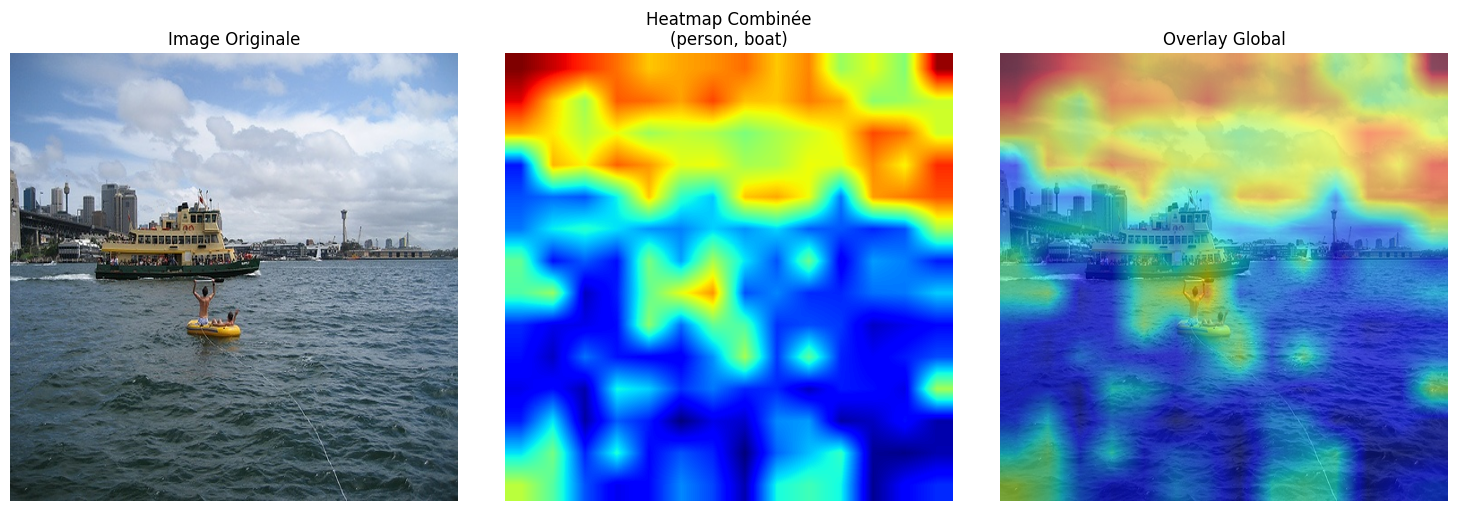

In [182]:
model1.eval()

# index = np.random.randint(0, len(dataset["test"]))
# sample = dataset["test"][index]

while True:
    index = np.random.randint(0, len(dataset["test"]))
    sample = dataset["test"][index]
    if len(sample["classes"]) > 1:
        break



image_pil = sample["image"]

class_index = sample["classes"]
class_name = VOC2007_CLASSES[class_index]

print(f"Visualisation de l'image n°{index} | Classe ciblée : '{class_name}'")

visualize_segmentation_dclip(model1, image_pil, class_name, device=device)

In [183]:
model2 = dclip(cfg, VOC2007_CLASSES)
model2 = model2.to(device)


--- [INIT DCLIP] ---
Logit Scale: 5
Fixed Text Features shape: torch.Size([40, 512]) (Attendu: [2*N, 512])
Detected ViT Output Dim: 512
Trainable parameters: 427,648


In [ ]:
asl_criterion = AsymmetricLossOptimized(gamma_neg=3, gamma_pos=1, clip=0.05).to(device)
mfi_criterion = MFILoss(lambda_coeff=0.2).to(device)

optimizer2 = torch.optim.SGD(
    [p for p in model2.parameters() if p.requires_grad],
    lr=0.002,
    momentum=0.9,
)

scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=30)

num_epochs = 30
best_map = 0.0
alpha = 7e-5 # celui de COCO divisé par le rapport de nombre de classe au carré (pour VOC)

print(f"Starting Training on {device}...")

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer2.zero_grad()

        logits, class_text_features = model2(images)
        
        loss_asl = asl_criterion(logits, labels)
            
        loss_mfi = mfi_criterion(class_text_features)

        loss = loss_asl + alpha * loss_mfi
    
        loss.backward()

        optimizer2.step()


        epoch_loss += loss.item()
        pbar.set_postfix({"ASL": f"{loss_asl.item():.4f}", "MFI": f"{alpha*loss_mfi.item():.4f}"})

    
    scheduler1.step()
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"\n--- Periodic Evaluation (Epoch {epoch}) ---")
        current_map, cp, inter_sim = evaluate_dclip_model(model2, test_loader, VOC2007_CLASSES, device=device)
        print(f"Test mAP: {current_map:.4f}  |  CP: {cp:.4f}  |  Sim: {inter_sim:.4f}")

        
        if current_map > best_map:
            best_map = current_map

print(f"\nTraining Finished! Best mAP attained: {best_map:.4f}")

Starting Training on cuda...


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.31it/s, ASL=24.5075, MFI=0.0202]



--- Periodic Evaluation (Epoch 1) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.33it/s]
/users/Etu6/21100696/M2/DEEPL/Projet/v1/eval.py:80: RuntimeWarning: invalid value encountered in divide
  denom = TP_per_class + FP_per_class


  mAP  : 0.1246
  CP   : 0.4053  (precision @ threshold 0.5)
  Inter-class sim : 0.9742  ← CLIP level, MFI not working yet
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.1246  |  CP: 0.4053  |  Sim: 0.9742


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.00it/s, ASL=25.7653, MFI=0.0191]



--- Periodic Evaluation (Epoch 5) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.07it/s]
/users/Etu6/21100696/M2/DEEPL/Projet/v1/eval.py:80: RuntimeWarning: invalid value encountered in divide
  denom = TP_per_class + FP_per_class


  mAP  : 0.1491
  CP   : 0.4053  (precision @ threshold 0.5)
  Inter-class sim : 0.9386  ← CLIP level, MFI not working yet
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.1491  |  CP: 0.4053  |  Sim: 0.9386


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.95it/s, ASL=10.5542, MFI=0.0045]



--- Periodic Evaluation (Epoch 10) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.04it/s]


  mAP  : 0.5320
  CP   : 0.1191  (precision @ threshold 0.5)
  Inter-class sim : 0.1835  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.5320  |  CP: 0.1191  |  Sim: 0.1835


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.96it/s, ASL=7.4782, MFI=0.0036]



--- Periodic Evaluation (Epoch 15) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.03it/s]


  mAP  : 0.8929
  CP   : 0.1286  (precision @ threshold 0.5)
  Inter-class sim : 0.2356  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.8929  |  CP: 0.1286  |  Sim: 0.2356


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.95it/s, ASL=5.7933, MFI=0.0024]



--- Periodic Evaluation (Epoch 20) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.04it/s]


  mAP  : 0.9102
  CP   : 0.1248  (precision @ threshold 0.5)
  Inter-class sim : 0.2137  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9102  |  CP: 0.1248  |  Sim: 0.2137


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.95it/s, ASL=4.6943, MFI=0.0022]



--- Periodic Evaluation (Epoch 25) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.05it/s]


  mAP  : 0.9132
  CP   : 0.1432  (precision @ threshold 0.5)
  Inter-class sim : 0.1987  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9132  |  CP: 0.1432  |  Sim: 0.1987


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.94it/s, ASL=4.9878, MFI=0.0022]



--- Periodic Evaluation (Epoch 30) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.03it/s]

  mAP  : 0.9151
  CP   : 0.1244  (precision @ threshold 0.5)
  Inter-class sim : 0.2231  ← well decorrelated
  (CLIP baseline ≈ 0.77, D-CLIP target ≈ 0.50)
Test mAP: 0.9151  |  CP: 0.1244  |  Sim: 0.2231

Training Finished! Best mAP attained: 0.9151


Visualisation de l'image n°4737 | Classe ciblée : '['person' 'chair']'


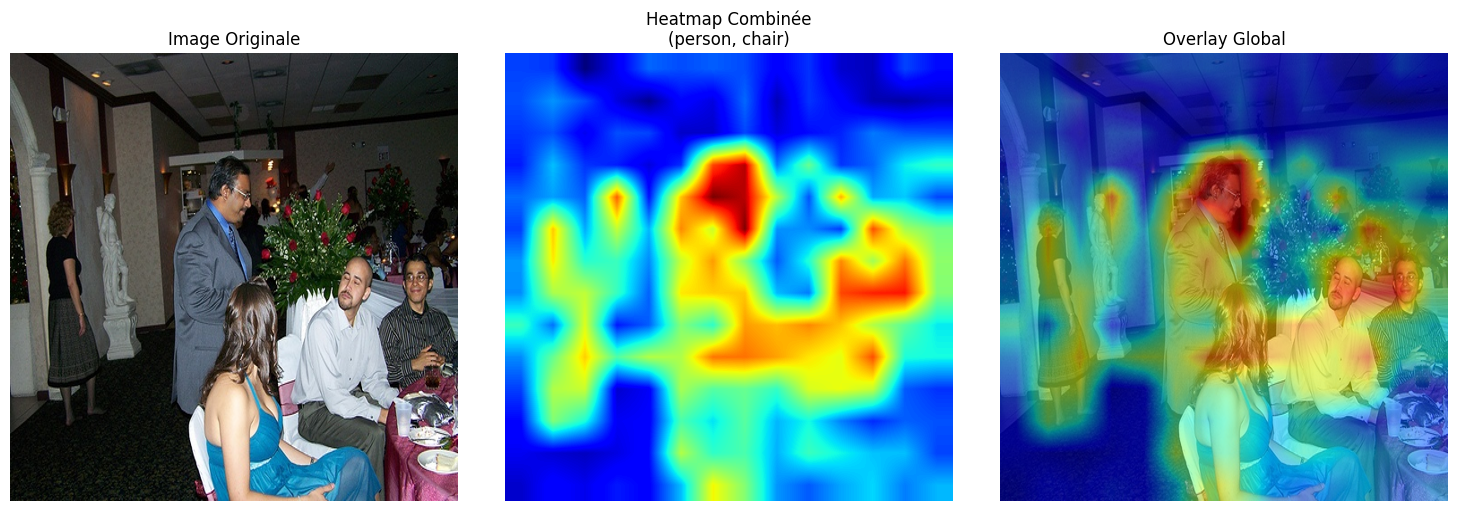

In [186]:
model2.eval()

# index = np.random.randint(0, len(dataset["test"]))
# sample = dataset["test"][index]

while True:
    index = np.random.randint(0, len(dataset["test"]))
    sample = dataset["test"][index]
    if len(sample["classes"]) > 1:
        break



image_pil = sample["image"]

class_index = sample["classes"]
class_name = VOC2007_CLASSES[class_index]

print(f"Visualisation de l'image n°{index} | Classe ciblée : '{class_name}'")

visualize_segmentation_dclip(model2, image_pil, class_name, device=device)

Chargement de CLIP Standard...
Image n°833 | Objets : ['dog' 'person']
--- RÉSULTAT CLIP OFFICIEL ---


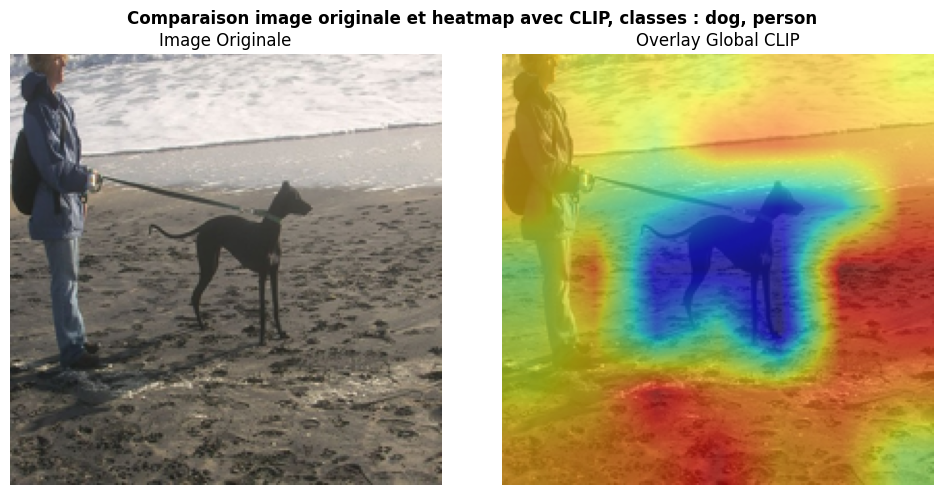

--- RÉSULTAT DCLIP (Ton Modèle) ---


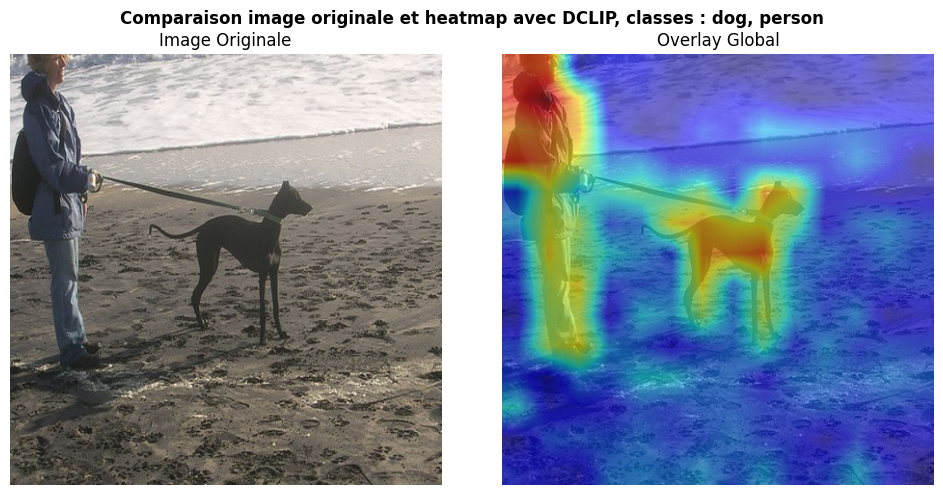

In [ ]:
# 1. Charger le vrai CLIP standard
print("Chargement de CLIP Standard...")
official_clip, official_preprocess = clip.load("ViT-B/32", device=device)


index = np.random.randint(0, len(dataset["test"]))
sample = dataset["test"][index]

# while True:
#     index = np.random.randint(0, len(dataset["test"]))
#     sample = dataset["test"][index]
#     if len(sample["classes"]) > 1:
#         break



image_pil = sample["image"]

class_index = sample["classes"]
class_names = VOC2007_CLASSES[class_index]

print(f"Image n°{index} | Objets : {class_names}")

# 3. Lancer la visualisation Standard CLIP
print("--- RÉSULTAT CLIP OFFICIEL ---")
visualize_combined_heatmap_standard_clip(official_clip, official_preprocess, image_pil, class_names, device=device)

# 4. Lancer la visualisation DCLIP (Pour comparer !)
print("--- RÉSULTAT DCLIP (Ton Modèle) ---")
visualize_segmentation_dclip(model, image_pil, class_names, device=device)

Génération de la figure de comparaison pour l'image n°4376...


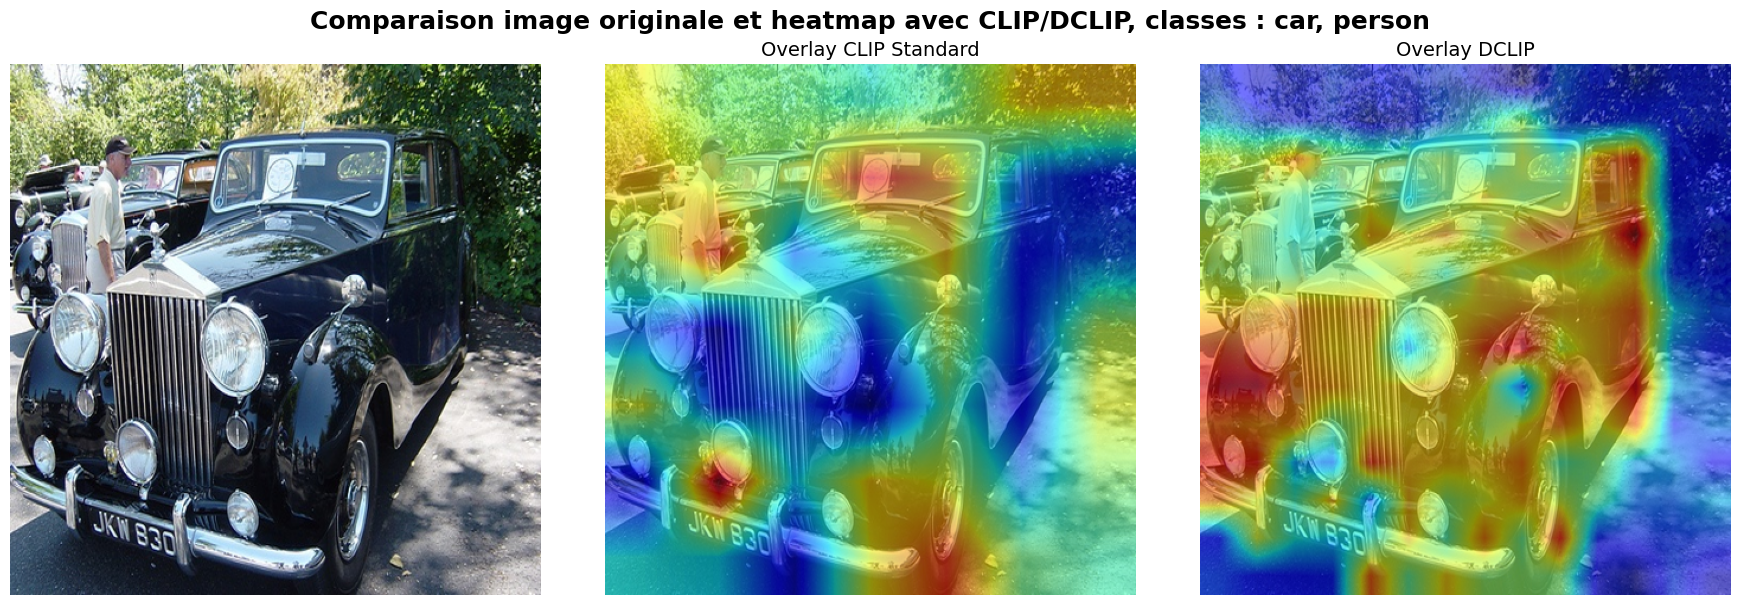

In [346]:
# index = np.random.randint(0, len(dataset["test"]))
# sample = dataset["test"][index]

while True:
    index = np.random.randint(0, len(dataset["test"]))
    sample = dataset["test"][index]
    if len(sample["classes"]) > 1:
        break

image_pil = sample["image"]
class_names = [VOC2007_CLASSES[i] for i in sample["classes"]] 

print(f"Génération de la figure de comparaison pour l'image n°{index}...")

# 2. Appel de la super-fonction (on lui passe les 2 modèles en même temps !)
visualize_comparison_clip_dclip(
    clip_model=official_clip, 
    preprocess=official_preprocess, 
    dclip_model=model, 
    image=image_pil, 
    class_names=class_names, 
    device=device
)

## ViT16

In [37]:
model, best_map = train_dclip(
    dclip(VOC2007_CLASSES, "ViT-B/16"),
    train_loader,
    test_loader,
    class_names=VOC2007_CLASSES,
    num_epochs=30,      
    lr=0.002,            
    alpha=7e-5,          
    eval_period=5,
    device="cuda"        
)


--- [INIT DCLIP] ---
Logit Scale: 7
Fixed Text Features shape: torch.Size([40, 512]) (Attendu: [2*N, 512])
Detected ViT Output Dim: 512
Trainable parameters: 427,648


Epoch 1/30: 100%|███████| 157/157 [01:32<00:00,  1.69it/s, ASL=13.3695, α*MFI=0.00203, Loss=13.3716]


Avg Epoch 1: ASL=40.3803 | α*MFI=0.00217 | Total=40.3825

--- Evaluation (Epoch 1) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [01:32<00:00,  1.67it/s]


  mAP    : 0.8236
  CP     : 0.7630
mAP: 0.8236 | CP: 0.7630 (Best: 0.8236)


Epoch 2/30:  76%|█████▎ | 119/157 [01:11<00:22,  1.65it/s, ASL=18.2604, α*MFI=0.00202, Loss=18.2624]


KeyboardInterrupt: 

In [39]:
model, best_map = train_dclip(
    dclip(VOC2007_CLASSES, "ViT-B/32"),
    train_loader,
    test_loader,
    class_names=VOC2007_CLASSES,
    num_epochs=30,      
    lr=0.002,            
    # alpha=7e-5,          
    alpha=0,
    eval_period=5,
    device="cuda"        
)


--- [INIT DCLIP] ---
Logit Scale: 7
Fixed Text Features shape: torch.Size([40, 512]) (Attendu: [2*N, 512])
Detected ViT Output Dim: 512
Trainable parameters: 427,648


Epoch 1/30: 100%|███████| 157/157 [00:21<00:00,  7.30it/s, ASL=11.4993, α*MFI=0.00000, Loss=11.4993]


Avg Epoch 1: ASL=37.0543 | α*MFI=0.00000 | Total=37.0543

--- Evaluation (Epoch 1) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.32it/s]


  mAP    : 0.7975
  CP     : 0.7594
mAP: 0.7975 | CP: 0.7594 (Best: 0.7975)


Epoch 2/30: 100%|█████████| 157/157 [00:21<00:00,  7.15it/s, ASL=9.7644, α*MFI=0.00000, Loss=9.7644]


Avg Epoch 2: ASL=18.5115 | α*MFI=0.00000 | Total=18.5115


Epoch 3/30: 100%|█████████| 157/157 [00:22<00:00,  7.06it/s, ASL=8.2302, α*MFI=0.00000, Loss=8.2302]


Avg Epoch 3: ASL=15.8397 | α*MFI=0.00000 | Total=15.8397


Epoch 4/30: 100%|█████████| 157/157 [00:22<00:00,  7.02it/s, ASL=4.4059, α*MFI=0.00000, Loss=4.4059]


Avg Epoch 4: ASL=14.6857 | α*MFI=0.00000 | Total=14.6857


Epoch 5/30: 100%|█████████| 157/157 [00:22<00:00,  6.98it/s, ASL=6.4645, α*MFI=0.00000, Loss=6.4645]


Avg Epoch 5: ASL=13.9021 | α*MFI=0.00000 | Total=13.9021

--- Evaluation (Epoch 5) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.06it/s]


  mAP    : 0.8967
  CP     : 0.7795
mAP: 0.8967 | CP: 0.7795 (Best: 0.8967)


Epoch 6/30: 100%|███████| 157/157 [00:22<00:00,  7.01it/s, ASL=11.3415, α*MFI=0.00000, Loss=11.3415]


Avg Epoch 6: ASL=13.4517 | α*MFI=0.00000 | Total=13.4517


Epoch 7/30: 100%|█████████| 157/157 [00:22<00:00,  6.99it/s, ASL=5.7455, α*MFI=0.00000, Loss=5.7455]


Avg Epoch 7: ASL=13.1837 | α*MFI=0.00000 | Total=13.1837


Epoch 8/30: 100%|█████████| 157/157 [00:22<00:00,  6.95it/s, ASL=4.8710, α*MFI=0.00000, Loss=4.8710]


Avg Epoch 8: ASL=12.7705 | α*MFI=0.00000 | Total=12.7705


Epoch 9/30: 100%|█████████| 157/157 [00:22<00:00,  6.94it/s, ASL=5.1128, α*MFI=0.00000, Loss=5.1128]


Avg Epoch 9: ASL=12.6552 | α*MFI=0.00000 | Total=12.6552


Epoch 10/30: 100%|████████| 157/157 [00:22<00:00,  6.92it/s, ASL=6.1807, α*MFI=0.00000, Loss=6.1807]


Avg Epoch 10: ASL=12.3471 | α*MFI=0.00000 | Total=12.3471

--- Evaluation (Epoch 10) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.03it/s]


  mAP    : 0.9075
  CP     : 0.6941
mAP: 0.9075 | CP: 0.6941 (Best: 0.9075)


Epoch 11/30: 100%|████████| 157/157 [00:22<00:00,  6.99it/s, ASL=5.8989, α*MFI=0.00000, Loss=5.8989]


Avg Epoch 11: ASL=12.1643 | α*MFI=0.00000 | Total=12.1643


Epoch 12/30: 100%|████████| 157/157 [00:22<00:00,  6.96it/s, ASL=7.4404, α*MFI=0.00000, Loss=7.4404]


Avg Epoch 12: ASL=12.0619 | α*MFI=0.00000 | Total=12.0619


Epoch 13/30: 100%|████████| 157/157 [00:22<00:00,  6.94it/s, ASL=8.4464, α*MFI=0.00000, Loss=8.4464]


Avg Epoch 13: ASL=11.8843 | α*MFI=0.00000 | Total=11.8843


Epoch 14/30: 100%|██████| 157/157 [00:22<00:00,  6.94it/s, ASL=12.4410, α*MFI=0.00000, Loss=12.4410]


Avg Epoch 14: ASL=11.8008 | α*MFI=0.00000 | Total=11.8008


Epoch 15/30: 100%|████████| 157/157 [00:22<00:00,  6.92it/s, ASL=6.2969, α*MFI=0.00000, Loss=6.2969]


Avg Epoch 15: ASL=11.7934 | α*MFI=0.00000 | Total=11.7934

--- Evaluation (Epoch 15) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.02it/s]


  mAP    : 0.9106
  CP     : 0.7376
mAP: 0.9106 | CP: 0.7376 (Best: 0.9106)


Epoch 16/30: 100%|████████| 157/157 [00:22<00:00,  7.00it/s, ASL=4.7892, α*MFI=0.00000, Loss=4.7892]


Avg Epoch 16: ASL=11.7013 | α*MFI=0.00000 | Total=11.7013


Epoch 17/30: 100%|████████| 157/157 [00:22<00:00,  6.95it/s, ASL=8.3480, α*MFI=0.00000, Loss=8.3480]


Avg Epoch 17: ASL=11.4502 | α*MFI=0.00000 | Total=11.4502


Epoch 18/30: 100%|████████| 157/157 [00:22<00:00,  6.95it/s, ASL=6.5127, α*MFI=0.00000, Loss=6.5127]


Avg Epoch 18: ASL=11.3677 | α*MFI=0.00000 | Total=11.3677


Epoch 19/30: 100%|████████| 157/157 [00:22<00:00,  6.93it/s, ASL=5.4429, α*MFI=0.00000, Loss=5.4429]


Avg Epoch 19: ASL=11.1744 | α*MFI=0.00000 | Total=11.1744


Epoch 20/30: 100%|████████| 157/157 [00:22<00:00,  6.94it/s, ASL=7.3439, α*MFI=0.00000, Loss=7.3439]


Avg Epoch 20: ASL=11.4876 | α*MFI=0.00000 | Total=11.4876

--- Evaluation (Epoch 20) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.04it/s]


  mAP    : 0.9113
  CP     : 0.7340
mAP: 0.9113 | CP: 0.7340 (Best: 0.9113)


Epoch 21/30: 100%|████████| 157/157 [00:22<00:00,  6.99it/s, ASL=5.6910, α*MFI=0.00000, Loss=5.6910]


Avg Epoch 21: ASL=11.1684 | α*MFI=0.00000 | Total=11.1684


Epoch 22/30: 100%|████████| 157/157 [00:22<00:00,  6.96it/s, ASL=5.0081, α*MFI=0.00000, Loss=5.0081]


Avg Epoch 22: ASL=11.2498 | α*MFI=0.00000 | Total=11.2498


Epoch 23/30: 100%|████████| 157/157 [00:22<00:00,  6.95it/s, ASL=6.9264, α*MFI=0.00000, Loss=6.9264]


Avg Epoch 23: ASL=11.0757 | α*MFI=0.00000 | Total=11.0757


Epoch 24/30: 100%|████████| 157/157 [00:22<00:00,  6.94it/s, ASL=4.1633, α*MFI=0.00000, Loss=4.1633]


Avg Epoch 24: ASL=10.8796 | α*MFI=0.00000 | Total=10.8796


Epoch 25/30: 100%|████████| 157/157 [00:22<00:00,  6.93it/s, ASL=4.7747, α*MFI=0.00000, Loss=4.7747]


Avg Epoch 25: ASL=10.9909 | α*MFI=0.00000 | Total=10.9909

--- Evaluation (Epoch 25) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.02it/s]


  mAP    : 0.9113
  CP     : 0.7448
mAP: 0.9113 | CP: 0.7448 (Best: 0.9113)


Epoch 26/30: 100%|██████| 157/157 [00:22<00:00,  6.93it/s, ASL=10.5304, α*MFI=0.00000, Loss=10.5304]


Avg Epoch 26: ASL=11.0092 | α*MFI=0.00000 | Total=11.0092


Epoch 27/30: 100%|████████| 157/157 [00:22<00:00,  6.91it/s, ASL=8.1697, α*MFI=0.00000, Loss=8.1697]


Avg Epoch 27: ASL=10.9117 | α*MFI=0.00000 | Total=10.9117


Epoch 28/30: 100%|████████| 157/157 [00:22<00:00,  6.94it/s, ASL=9.6211, α*MFI=0.00000, Loss=9.6211]


Avg Epoch 28: ASL=10.9138 | α*MFI=0.00000 | Total=10.9138


Epoch 29/30: 100%|████████| 157/157 [00:22<00:00,  6.92it/s, ASL=7.5574, α*MFI=0.00000, Loss=7.5574]


Avg Epoch 29: ASL=10.8812 | α*MFI=0.00000 | Total=10.8812


Epoch 30/30: 100%|████████| 157/157 [00:22<00:00,  6.93it/s, ASL=5.2305, α*MFI=0.00000, Loss=5.2305]


Avg Epoch 30: ASL=10.9290 | α*MFI=0.00000 | Total=10.9290

--- Evaluation (Epoch 30) ---


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:22<00:00,  7.02it/s]

  mAP    : 0.9113
  CP     : 0.7434
mAP: 0.9113 | CP: 0.7434 (Best: 0.9113)

Training Finished! Best mAP: 0.9113
